Imports: 

In [65]:
import pandas as pd 
% matplotlib inline 
from matplotlib import pyplot as plt 

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns

import warnings # this is to suppress an annoying warning from sklearn 
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
pd.options.mode.chained_assignment = None  # default='warn'

plt.style.use('seaborn')

Getting the raw data:

In [66]:
train = pd.read_csv('../data/sales_data.csv', 
                    low_memory=False)  # this is used to ensure that it checks the types properly 

# Understanding the data

In [67]:
def prepare_index(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'],      
                                   format='%Y-%m-%d')   
    df.set_index(['Date', 'Store'], inplace=True)      
    df.sort_index(inplace=True)
    return df

def prepare_features(df):    
    df = df.copy()
    df['Previous day sales'] = df.groupby('Store')['Sales'].shift(1)    
    df['Sales 6 days before'] = df.groupby('Store')['Sales'].shift(6)
    
    df.dropna(inplace=True)
    return df

def prepare_target(df):
    df = df.copy()
    df['Next day sales'] = df.groupby('Store')['Sales'].shift(-1)
    df.dropna(inplace=True)
    return df

Let's apply all this to the training set: 

In [68]:
# first the index: 
train_with_prepared_index = prepare_index(train)
# now building some extra features 
train_with_prepared_features = prepare_features(train_with_prepared_index)
# and finally prepare the target (because we'll need this to train)
train_fully_prepared = prepare_target(train_with_prepared_features)

Let's get an idea of what the data looks like: 

In [69]:
print('Training data:')
print('Format:   ', train.shape)
print('Min date: ', train_with_prepared_index.index.get_level_values('Date').min())
print('Max date: ', train_with_prepared_index.index.get_level_values('Date').max())
print('\nTraining data after building features:')
print('Format:   ', train_with_prepared_features.shape)
print('Min date: ', train_with_prepared_features.index.get_level_values('Date').min())
print('Max date: ', train_with_prepared_features.index.get_level_values('Date').max())
print('\nTraining data after adding the target:')
print('Format:   ', train_fully_prepared.shape)
print('Min date: ', train_fully_prepared.index.get_level_values('Date').min())
print('Max date: ', train_fully_prepared.index.get_level_values('Date').max())

Training data:
Format:    (473922, 13)
Min date:  2013-01-01 00:00:00
Max date:  2015-05-29 00:00:00

Training data after building features:
Format:    (470574, 13)
Min date:  2013-01-07 00:00:00
Max date:  2015-05-29 00:00:00

Training data after adding the target:
Format:    (470016, 14)
Min date:  2013-01-07 00:00:00
Max date:  2015-05-28 00:00:00


### Now for fitting regressors! 

In [70]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import median_absolute_error, r2_score

Let's make a small RF:  

In [71]:
rf = RandomForestRegressor(n_estimators=10, 
                      max_depth=10, 
                      n_jobs=-1)

Define our features (because we don't want to use the categoricals for now), and target:

In [72]:
features = [
    'Customers',
    'DayOfWeek',
    'Next day is Open',
    'Next day is SchoolHoliday',
    #'Next day is StateHoliday',
    'Next day is a Promo',
    'Open',
    'Previous day sales',
    'Promo',
    'Sales',
    'Sales 6 days before',
    'SchoolHoliday',
    #'StateHoliday'
]

target = 'Next day sales'

Fit the model: 

In [73]:
%%time 
rf.fit(X=train_fully_prepared[features], 
       y=train_fully_prepared[target]);

CPU times: user 17.3 s, sys: 233 ms, total: 17.5 s
Wall time: 6.77 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Let's get the day before the one we want to predict: 

In [74]:
last_day_we_have = pd.to_datetime(train['Date'],   # <--- notice this is the "raw" training set 
                                  format='%Y-%m-%d').max()

print(last_day_we_have)

2015-05-29 00:00:00


Let's get the data on that day: 

In [75]:
# note how we use train_with_prepared_features here, because train_fully_prepared does not have the last day
last_day_data = train_with_prepared_features.xs(last_day_we_have, 
                                                level='Date')

... and predict the sales on the next day! (remember, we didn't actually have a target for this day) 

In [76]:
last_day_data['Predictions for next day'] = rf.predict(last_day_data[features])

Quick glance: 

In [77]:
last_day_data[['Sales', 'Predictions for next day']].head()

,Sales,Predictions for next day
Store,,
1,4656,4435.090368
2,4541,2916.135999
3,7421,4922.285900
4,10529,9834.474985
6,5435,3232.746382


# How well did we do ?

Let's import some new data then! 

In [78]:
future = pd.read_csv('../data/sales_data_recent.csv', low_memory=False)

Do we have the next day? 

In [79]:
day_we_predicted = last_day_we_have + pd.offsets.Day(1)
print(day_we_predicted)

2015-05-30 00:00:00


In [80]:
future_prepared_index = prepare_index(future)

In [81]:
future_prepared_index.head()

DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date       Store                                                          
2015-05-30 1              6   5592        580     1      0            0   
           2              6   3447        513     1      0            0   
           3              6   4542        458     1      0            0   
           4              6  12187       1590     1      0            0   
           6              6   3756        394     1      0            0   

                  SchoolHoliday  Next day is SchoolHoliday  \
Date       Store                                             
2015-05-30 1                  0                          0   
           2                  0                          0   
           3                  0                          0   
           4                  0                          0   
           6                  0                          0   

                 Next day is StateHoliday  Next day is a Promo  \
Date       Store                                                 
2015-05-30 1                            0                    0   
           2                            0                    0   
           3                            0                    0   
           4                            0                    0   
           6                            0                    0   

                  Next day is Open  
Date       Store                    
2015-05-30 1                     0  
           2                     0  
           3                     0  
           4                     0  
           6                     0

Notice that we didn't create a target or the features. For now, we just care about the features.

In [82]:
new_day_data = future_prepared_index.xs(day_we_predicted, level='Date')

Now for a bit of Pandas magic: we're going to concatenate the two series, on the key Store, so that we can compare them: 

In [83]:
new_day_data.shape

(558, 11)

In [84]:
new_day_data.head()

,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Next day is SchoolHoliday,Next day is StateHoliday,Next day is a Promo,Next day is Open
Store,,,,,,,,,,,
1,6,5592,580,1,0,0,0,0,0,0,0
2,6,3447,513,1,0,0,0,0,0,0,0
3,6,4542,458,1,0,0,0,0,0,0,0
4,6,12187,1590,1,0,0,0,0,0,0,0
6,6,3756,394,1,0,0,0,0,0,0,0


In [85]:
last_day_data.shape

(558, 14)

In [86]:
last_day_data.head()

,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Next day is SchoolHoliday,Next day is StateHoliday,Next day is a Promo,Next day is Open,Previous day sales,Sales 6 days before,Predictions for next day
Store,,,,,,,,,,,,,,
1,5,4656,537,1,0,0,0,0,0,0,1,4111.0,4276.0,4435.090368
2,5,4541,576,1,0,0,0,0,0,0,1,4049.0,2732.0,2916.135999
3,5,7421,793,1,0,0,0,0,0,0,1,6475.0,4613.0,4922.285900
4,5,10529,1366,1,0,0,0,0,0,0,1,8550.0,10118.0,9834.474985
6,5,5435,612,1,0,0,0,0,0,0,1,4754.0,3253.0,3232.746382


We only want the "`predictions for the next day`" (on "`last_day_data`" ) and the "`sales`" of the "`new_day_data`"

In [87]:
results = pd.concat([
           last_day_data['Predictions for next day'],
           new_day_data['Sales'], 
           ], 
          axis=1)

In [88]:
results.head(5)

,Predictions for next day,Sales
Store,,
1,4435.090368,5592
2,2916.135999,3447
3,4922.285900,4542
4,9834.474985,12187
6,3232.746382,3756


In [89]:
from sklearn.metrics import r2_score

In [90]:
r2_score(results['Sales'], results['Predictions for next day'])

0.85817618240024407

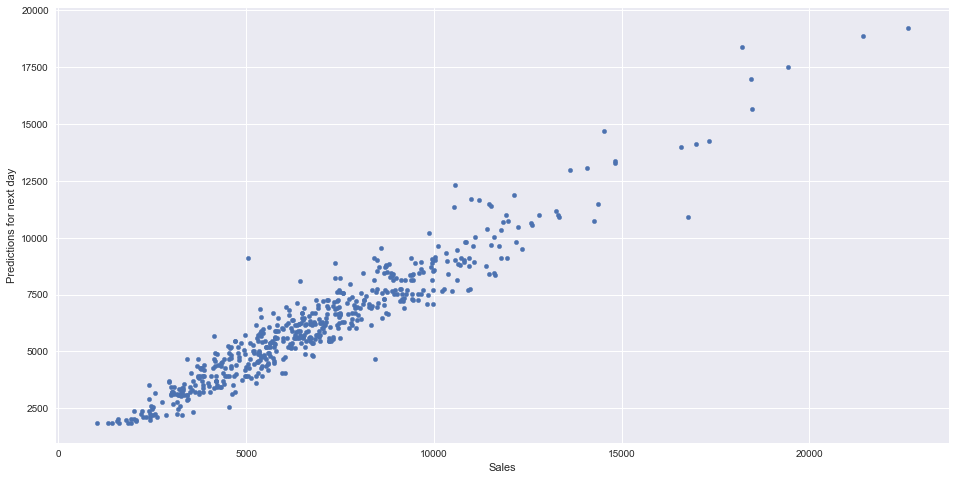

In [91]:
results.plot(kind='scatter', 
             x='Sales', 
             y='Predictions for next day', 
             figsize=(16, 8))

Now, to put it all together into functions. 

# Making the whole thing parametrized: 

We're going to build new features, but we might want to avoid having to update the feature list, so let's use this: 

In [108]:
def get_feature_names(prepared_train):
    not_features = ['StateHoliday', 'Next day is StateHoliday', 'target']

    features = [col for col in prepared_train.columns if
            col not in not_features]
    
    return features

In [109]:
def prepare_index(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'],      
                                   format='%Y-%m-%d')   
    df.set_index(['Date', 'Store'], inplace=True)      
    df.sort_index(inplace=True)
    return df

def prepare_features(df):    
    df = df.copy()
    df['Previous day sales'] = df.groupby('Store')['Sales'].shift(1)    
    df['Sales 6 days before'] = df.groupby('Store')['Sales'].shift(6)
    
    df.dropna(inplace=True)
    return df


In [110]:
def fully_prepare_train(raw_train):
    prepared_train = prepare_features(prepare_index(raw_train))  # <-- prepare the training set 
    feature_names = get_feature_names(prepared_train)
    prepared_train_with_target = get_train_target(prepared_train)
    return prepared_train_with_target, feature_names

In [111]:
def cross_validate_model(raw_train, model):
    prepared_train_with_target, feature_names = fully_prepare_train(raw_train)
    
    target = 'Next day sales'
    
    cv_score = cross_val_score(estimator=model, 
                    X=prepared_train_with_target[features],
                    y=prepared_train_with_target[target], 
                    scoring='r2')
    
    return cv_score

In [121]:
def train_and_predict_next_day(raw_train, model):
    prepared_train_without_target = prepare_features(prepare_index(raw_train))
    prepared_train_with_target, feature_names = fully_prepare_train(raw_train)
    
    target = 'Next day sales'

    model.fit(X=prepared_train_with_target[features],
              y=prepared_train_with_target[target])
    
    last_day_we_have = pd.to_datetime(raw_train['Date'],
                                      format='%Y-%m-%d').max()
    print(last_day_we_have)

    last_day_data = train_with_prepared_features.xs(last_day_we_have, 
                                                level='Date')

    last_day_data['Predictions for next day'] = model.predict(
        last_day_data[features])

    predictions = last_day_data['Predictions for next day']
    return predictions

Let's do a quick run, to get our baseline result: 

In [118]:
def get_the_first_day_from_test(test_set):
    first_day_of_the_test_set = pd.to_datetime(test_set['Date'], format='%Y-%m-%d').min()
    print(first_day_of_the_test_set)
    
    future_prepared_index = prepare_index(test_set)
    new_day_data = future_prepared_index.xs(day_we_predicted, level='Date')
    return new_day_data['Sales']

In [119]:
train = pd.read_csv('../data/sales_data.csv', low_memory=False)
test = pd.read_csv('../data/sales_data_recent.csv', low_memory=False)

In [122]:
predictions = train_and_predict_next_day(train, model=RandomForestRegressor())

true_values = get_the_first_day_from_test(test)

results = pd.concat([true_values, predictions], axis=1)
print('R2 = %0.2f' % (r2_score(results['Sales'], results['Predictions for next day'])))

2015-05-29 00:00:00
2015-05-30 00:00:00
R2 = 0.90


So, with the work we've done so far, we can predict with this R2. 

# Improving the regressor: 

In [ ]:
models = {
    'rf_base': RandomForestRegressor(n_jobs=-1),
    'rf_deep': RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1),
    'tree_base': DecisionTreeRegressor(),
    'tree_deep': DecisionTreeRegressor(max_depth=15),
}

In [ ]:
performance = {}
for model in models:
    print('working on %s' % model, end = ', ')
    %time performance[model] = cross_validate_model(train, models[model]).mean()

In [ ]:
pd.Series(performance).sort_values(ascending=False)

In [ ]:
def prepare_features(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df.set_index('date', inplace=True)  # make the date the index
    df.sort_index(inplace=True)  # sort the dataset on the index
    df['Previous day sales'] = df.groupby('Store')['Sales'].shift(1)
    df['Sales 6 days before'] = df.groupby('Store')['Sales'].shift(6)
    
    # some new features 
    for i in range(1, 5): 
        new_col_name = 'Sales %s days before' % str(i)
    df[new_col_name] = df.groupby('Store')['Sales'].shift(i)
    df.dropna(inplace=True)
    return df

In [ ]:
performance['exp1: Adding previous sales days'] = cross_validate_model(train, models['rf_deep']).mean()
pd.Series(performance).sort_values(ascending=False)

In [ ]:
def prepare_features(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df.set_index('date', inplace=True)  # make the date the index
    df.sort_index(inplace=True)  # sort the dataset on the index
    df['Previous day sales'] = df.groupby('Store')['Sales'].shift(1)
    df['Sales 6 days before'] = df.groupby('Store')['Sales'].shift(6)
    
    # some new features 
    for i in range(1, 5): 
        new_col_name = 'Sales %s days before' % str(i)
    df[new_col_name] = df.groupby('Store')['Sales'].shift(i)
    
    # adding some rolling windows: 
    for i in range(1, 5): 
        new_col_name = 'Rolling window of sales %s from days before' % str(i)
    df[new_col_name] = df['Sales'].rolling(i).mean()
    
    df.dropna(inplace=True)
    return df

In [ ]:
performance['exp2: Adding a few rolling windows of sales'] = cross_validate_model(train, models['rf_deep']).mean()
pd.Series(performance).sort_values(ascending=False)

Also, another interesting question is how our sales the previous day compared to the sales of the previous week

In [ ]:
def prepare_features(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df.set_index('date', inplace=True)  # make the date the index
    df.sort_index(inplace=True)  # sort the dataset on the index
    df['Previous day sales'] = df.groupby('Store')['Sales'].shift(1)
    df['Sales 6 days before'] = df.groupby('Store')['Sales'].shift(6)
    
    # some new features 
    for i in range(1, 2): 
        new_col_name = 'Sales %s days before' % str(i)
    df[new_col_name] = df.groupby('Store')['Sales'].shift(i)
    
    # adding some rolling windows: 
    for i in range(1, 2): 
        new_col_name = 'Rolling window of sales %s from days before' % str(i)
    df[new_col_name] = df['Sales'].rolling(i).mean()
    
    df['Previous week same day'] = df.groupby(['Store', 'DayOfWeek'])['Sales'].shift(1)
    df.dropna(inplace=True)
    df['Week on week sales ratio'] = df['Sales'] / df['Previous week same day']
    df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    df.drop('Previous week same day', axis=1, inplace=True)
    
    df.dropna(inplace=True)
    
    return df

In [ ]:
performance['exp3: Adding the sales ratios between consecutive weeks'] = cross_validate_model(train, models['rf_deep']).mean()
pd.Series(performance).sort_values(ascending=False)

So, we've been increasing our performance on cross validation, maybe it's time for another attempt. However, we should remember that some days (for instance holidays) are really easy to predict, so our score will probably be lower than the cross validation score. 

### Excellent, now let's see how we did

In [ ]:
train = pd.read_csv('sales_data.csv', low_memory=False)

#predictions = train_and_predict_next_day(train, 
#                                         model=models['rf_deep'])
predictions = train_and_predict_next_day(train, 
                                         model=RandomForestRegressor())


results = pd.concat([true_values, predictions], axis=1)
print('R2 = %0.2f' % (r2_score(results['Sales'], results['Predictions for next day'])))

Worse? Why?

Options: 
- You actually dno't have the sales ratio 
- you might have too much noise from building those extra features, which are larger in number than the ones you now have 
- A feature selection step might help with that 